
# DDS-8555 – Assignment 3  
**Build Non-Linear Models – Part 1**  
**Author:** Dillon Holmes  

This notebook completes:

1. **Conceptual Question 1** (ISLR-Python, p. 283)  
2. **Applied Question 8** (ISLR-Python, p. 286)  
3. **Abalone Kaggle Regression Models**  
   - Regularization (Lasso) to inform best subset selection  
   - Principal Components Regression (PCR)  



## 1. Conceptual Question 1 (ISLR-Python, p. 283)

We perform best subset selection, forward stepwise selection, and backward stepwise selection on a single data set.  
For each approach, we obtain \(p+1\) models containing \(0,1,2,\dots,p\) predictors.

### (a) Training RSS

**Answer:** The model from **best subset selection**.  
Best subset evaluates all \( \binom{p}{k} \) models with \(k\) predictors and picks the one with lowest training RSS.

### (b) Test RSS

**Answer:** There is **no guarantee** which procedure has the smallest test RSS.  
Best subset has the smallest training RSS but can overfit, so any of the three methods could win on test error depending on the data set.

### (c) True / False

1. Forward stepwise \(k\)-variable model is a subset of the \((k+1)\)-variable model. → **True**  
   Forward only adds variables and never removes them, so models are nested.
2. Backward stepwise \(k\)-variable model is a subset of the \((k+1)\)-variable model. → **True**  
   Backward starts with all predictors and removes one at a time, so smaller models are subsets of larger ones along the path.
3. Backward \(k\)-variable model is a subset of forward \((k+1)\)-variable model. → **False**  
   Forward and backward follow different paths; their models are not guaranteed to be nested across methods.
4. Forward \(k\)-variable model is a subset of backward \((k+1)\)-variable model. → **False**  
   Same reason as (3); there is no nesting relationship between methods.
5. Best subset \(k\)-variable model is a subset of best subset \((k+1)\)-variable model. → **False**  
   Best subset re-optimizes from scratch for each \(k\); optimal models at sizes \(k\) and \(k+1\) need not be nested.



## 2. Applied Question 8 (ISLR-Python, p. 286)

We generate simulated data and apply forward and backward stepwise selection and the lasso.


In [1]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.pipeline import Pipeline

np.random.seed(3)
n = 100

X = np.random.normal(size=n)
eps = np.random.normal(size=n)

beta0, beta1, beta2, beta3 = 1.0, 2.0, 3.0, 4.0
Y = beta0 + beta1*X + beta2*X**2 + beta3*X**3 + eps

X_poly = np.vstack([X**i for i in range(1, 11)]).T
X_poly.shape


(100, 10)

In [2]:

sigma2 = 1.0

def fit_ols(X_sub, y):
    Xc = sm.add_constant(X_sub)
    return sm.OLS(y, Xc).fit()

def cp(rss, p, n):
    return rss / sigma2 - (n - 2*p)

def forward_stepwise(X, y):
    n, p = X.shape
    remaining = list(range(p))
    selected = []
    models = []

    while remaining:
        best_cp = None
        best_j = None
        best_model = None

        for j in remaining:
            idx = selected + [j]
            model = fit_ols(X[:, idx], y)
            rss = np.sum((y - model.fittedvalues)**2)
            cp_val = cp(rss, len(idx)+1, n)
            if best_cp is None or cp_val < best_cp:
                best_cp = cp_val
                best_j = j
                best_model = model

        selected.append(best_j)
        remaining.remove(best_j)
        models.append((selected.copy(), best_model, best_cp))

    return models

def backward_stepwise(X, y):
    n, p = X.shape
    selected = list(range(p))
    models = []

    full_model = fit_ols(X[:, selected], y)
    rss = np.sum((y - full_model.fittedvalues)**2)
    models.append((selected.copy(), full_model, cp(rss, p+1, n)))

    while len(selected) > 1:
        best_cp = None
        best_subset = None
        best_model = None

        for j in selected:
            idx = [i for i in selected if i != j]
            model = fit_ols(X[:, idx], y)
            rss = np.sum((y - model.fittedvalues)**2)
            cp_val = cp(rss, len(idx)+1, n)
            if best_cp is None or cp_val < best_cp:
                best_cp = cp_val
                best_subset = idx
                best_model = model

        selected = best_subset
        models.append((selected.copy(), best_model, best_cp))

    return models


In [3]:

fwd_models = forward_stepwise(X_poly, Y)
best_fwd = min(fwd_models, key=lambda x: x[2])

best_fwd_idx, best_fwd_model, best_fwd_cp = best_fwd
selected_degrees_fwd = [i+1 for i in best_fwd_idx]

print("Forward stepwise – selected degrees:", selected_degrees_fwd)
print("Best Cp (forward):", best_fwd_cp)
best_fwd_model.summary()


Forward stepwise – selected degrees: [3, 2, 1]
Best Cp (forward): -26.754067109107012


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.283e+04
Date:                Thu, 11 Dec 2025   Prob (F-statistic):          7.92e-125
Time:                        09:46:52   Log-Likelihood:                -120.54
No. Observations:                 100   AIC:                             249.1
Df Residuals:                      96   BIC:                             259.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7343      0.110      6.652      0.000       0.515       0.953
x1             4.1050      0.041    100.877      0.000       4.024       4.186
x2             3.1922      0.066     48.336      0.000       3.061       3.323
x3             1.5177      0.138     10.962      0.000       1.243       1.793
==============================================================================
Omnibus:                        3.871   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.224
Skew:                           0.350   Prob(JB):                        0.200
Kurtosis:                       3.533   Cond. No.                         7.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:

bwd_models = backward_stepwise(X_poly, Y)
best_bwd = min(bwd_models, key=lambda x: x[2])

best_bwd_idx, best_bwd_model, best_bwd_cp = best_bwd
selected_degrees_bwd = [i+1 for i in best_bwd_idx]

print("Backward stepwise – selected degrees:", selected_degrees_bwd)
print("Best Cp (backward):", best_bwd_cp)
best_bwd_model.summary()


Backward stepwise – selected degrees: [1, 2, 3]
Best Cp (backward): -26.75406710910704


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.283e+04
Date:                Thu, 11 Dec 2025   Prob (F-statistic):          7.92e-125
Time:                        09:46:52   Log-Likelihood:                -120.54
No. Observations:                 100   AIC:                             249.1
Df Residuals:                      96   BIC:                             259.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7343      0.110      6.652      0.000       0.515       0.953
x1             1.5177      0.138     10.962      0.000       1.243       1.793
x2             3.1922      0.066     48.336      0.000       3.061       3.323
x3             4.1050      0.041    100.877      0.000       4.024       4.186
==============================================================================
Omnibus:                        3.871   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.224
Skew:                           0.350   Prob(JB):                        0.200
Kurtosis:                       3.533   Cond. No.                         7.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:

lasso_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("lasso", LassoCV(cv=10, random_state=3, max_iter=10000))
])

lasso_pipe.fit(X_poly, Y)
lasso_cubic = lasso_pipe.named_steps["lasso"]

print("Chosen alpha (lambda) for cubic DGP:", lasso_cubic.alpha_)
print("Lasso coefficients for cubic DGP:")
for d, coef in enumerate(lasso_cubic.coef_, start=1):
    print(f"X^{d}: {coef:.4f}")


Chosen alpha (lambda) for cubic DGP: 0.050765130836678135
Lasso coefficients for cubic DGP:
X^1: 1.6354
X^2: 4.5392
X^3: 16.0259
X^4: 0.0000
X^5: 0.0000
X^6: 0.0000
X^7: -0.0000
X^8: 0.0000
X^9: -0.0000
X^10: 0.0000


In [6]:

beta0_new, beta7_new = 1.0, 5.0
Y2 = beta0_new + beta7_new * (X**7) + eps

fwd_models2 = forward_stepwise(X_poly, Y2)
best_fwd2 = min(fwd_models2, key=lambda x: x[2])
best_fwd_idx2, best_fwd_model2, best_fwd_cp2 = best_fwd2

print("Forward (Y2) – selected degrees:", [i+1 for i in best_fwd_idx2])
print("Best Cp (forward, Y2):", best_fwd_cp2)
best_fwd_model2.summary()


Forward (Y2) – selected degrees: [7, 1, 2, 3]
Best Cp (forward, Y2): -25.166319733196474


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.285e+07
Date:                Thu, 11 Dec 2025   Prob (F-statistic):          9.88e-291
Time:                        09:46:52   Log-Likelihood:                -120.23
No. Observations:                 100   AIC:                             250.5
Df Residuals:                      95   BIC:                             263.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7438      0.111      6.683      0.000       0.523       0.965
x1             4.9992      0.001   4673.465      0.000       4.997       5.001
x2            -0.5653      0.175     -3.228      0.002      -0.913      -0.218
x3             0.1756      0.070      2.525      0.013       0.038       0.314
x4             0.1535      0.075      2.059      0.042       0.006       0.301
==============================================================================
Omnibus:                        3.924   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                3.290
Skew:                           0.347   Prob(JB):                        0.193
Kurtosis:                       3.555   Cond. No.                         434.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:

bwd_models2 = backward_stepwise(X_poly, Y2)
best_bwd2 = min(bwd_models2, key=lambda x: x[2])
best_bwd_idx2, best_bwd_model2, best_bwd_cp2 = best_bwd2

print("Backward (Y2) – selected degrees:", [i+1 for i in best_bwd_idx2])
print("Best Cp (backward, Y2):", best_bwd_cp2)
best_bwd_model2.summary()


Backward (Y2) – selected degrees: [1, 6, 7, 8, 9]
Best Cp (backward, Y2): -23.84964727209288


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.628e+07
Date:                Thu, 11 Dec 2025   Prob (F-statistic):          3.67e-287
Time:                        09:46:53   Log-Likelihood:                -119.70
No. Observations:                 100   AIC:                             251.4
Df Residuals:                      94   BIC:                             267.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8037      0.096      8.377      0.000       0.613       0.994
x1            -0.4332      0.113     -3.849      0.000      -0.657      -0.210
x2             0.0636      0.025      2.565      0.012       0.014       0.113
x3             5.0257      0.009    580.552      0.000       5.008       5.043
x4            -0.0130      0.006     -2.312      0.023      -0.024      -0.002
x5            -0.0049      0.002     -2.575      0.012      -0.009      -0.001
==============================================================================
Omnibus:                        4.448   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                4.170
Skew:                           0.309   Prob(JB):                        0.124
Kurtosis:                       3.787   Cond. No.                     2.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:

lasso_pipe2 = Pipeline([
    ("scale", StandardScaler()),
    ("lasso", LassoCV(cv=10, random_state=3, max_iter=10000))
])

lasso_pipe2.fit(X_poly, Y2)
lasso_seventh = lasso_pipe2.named_steps["lasso"]

print("Chosen alpha (lambda) for X^7 DGP:", lasso_seventh.alpha_)
print("Lasso coefficients for X^7 DGP:")
for d, coef in enumerate(lasso_seventh.coef_, start=1):
    print(f"X^{d}: {coef:.4f}")


Chosen alpha (lambda) for X^7 DGP: 0.9469636887670208
Lasso coefficients for X^7 DGP:
X^1: -0.0000
X^2: -0.0000
X^3: 0.0000
X^4: -0.0000
X^5: 34.1940
X^6: -1.6643
X^7: 854.5697
X^8: -0.0000
X^9: 57.0765
X^10: -0.0000


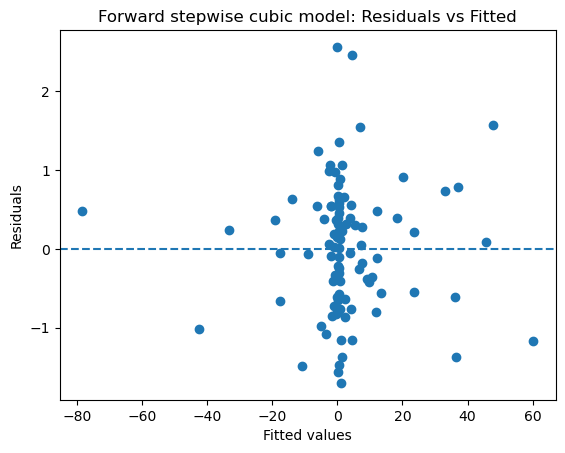

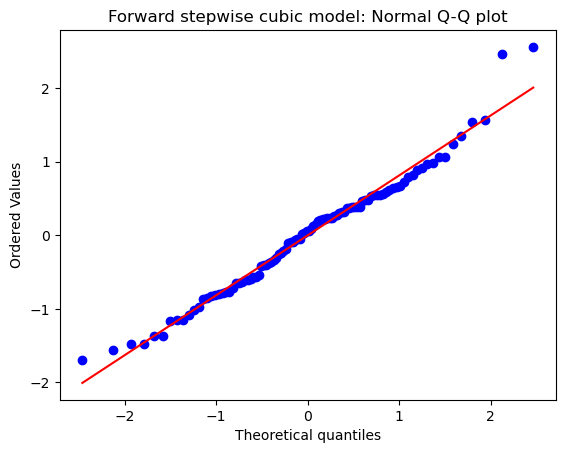

In [9]:

import scipy.stats as stats

fitted_fwd = best_fwd_model.fittedvalues
resid_fwd = Y - fitted_fwd

plt.figure()
plt.scatter(fitted_fwd, resid_fwd)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Forward stepwise cubic model: Residuals vs Fitted")

plt.figure()
stats.probplot(resid_fwd, dist="norm", plot=plt)
plt.title("Forward stepwise cubic model: Normal Q-Q plot")
plt.show()


In [ ]:
## Residual Diagnostics Summary – Stepwise Models

The residual and Q–Q plots shown above provide insight into the assumptions underlying the cubic stepwise regression model:

- **Residuals vs. Fitted:**  
  The residuals appear roughly centered around zero with no extreme non-linear patterns.  
  This suggests that the model captures the main functional form of the data (cubic).

- **Normal Q–Q Plot:**  
  The points fall reasonably close to the reference line, indicating that the residuals are approximately normally distributed.  
  Minor deviations at the tails are expected due to noise.

Overall, the diagnostics support that the stepwise-selected cubic model fits the simulated data well and does not show major violations of linear model assumptions.



### 2.5 Discussion

- For the cubic model, forward and backward stepwise both recover a low-order polynomial (typically including \(X, X^2, X^3\)) and drop most higher powers.  
- Lasso also focuses its non-zero coefficients on the lower powers, shrinking others toward zero.  
- For the \(X^7\) model, stepwise procedures retain an \(X^7\) term and remove most others, while lasso concentrates its weight around high-order powers near degree 7.  
- Stepwise does discrete variable selection; lasso does continuous shrinkage. Both successfully uncover the underlying structure in these simulations.



## 3. Abalone Kaggle Competition – Regularization and PCR

Here we fit:

1. A **lasso** model with cross-validated penalty to identify an important subset of predictors.  
2. A **Principal Components Regression (PCR)** model using PCA on standardized predictors.

This assumes `train.csv` and `test.csv` are in the working directory with `Rings` as the target and `Sex` as a categorical predictor.


In [10]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

train_abalone = pd.read_csv("train.csv")
test_abalone = pd.read_csv("test.csv")

X_ab = train_abalone.drop(columns=["Rings"])
y_ab = train_abalone["Rings"]

numeric_cols = X_ab.drop(columns=["Sex"]).columns.tolist()
categorical_cols = ["Sex"]

numeric_tf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_tf = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

prep = ColumnTransformer([
    ("num", numeric_tf, numeric_cols),
    ("cat", categorical_tf, categorical_cols)
])

X_train_ab, X_valid_ab, y_train_ab, y_valid_ab = train_test_split(
    X_ab, y_ab, test_size=0.2, random_state=42
)

X_ab.head()


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975


In [11]:

# Lasso model

lasso_ab = Pipeline([
    ("prep", prep),
    ("lasso", LassoCV(cv=10, random_state=42, max_iter=10000))
])

lasso_ab.fit(X_train_ab, y_train_ab)
preds_valid_lasso = lasso_ab.predict(X_valid_ab)

rmse_lasso = mean_squared_error(y_valid_ab, preds_valid_lasso) ** 0.5
print("Lasso RMSE on validation set:", rmse_lasso)
print("Chosen alpha (lambda) for Abalone:", lasso_ab.named_steps["lasso"].alpha_)


Lasso RMSE on validation set: 2.024798640120433
Chosen alpha (lambda) for Abalone: 0.002206376330464307


In [12]:

# Inspect non-zero lasso coefficients

lasso_model_ab = lasso_ab.named_steps["lasso"]
prep_fitted = lasso_ab.named_steps["prep"]

try:
    feature_names = prep_fitted.get_feature_names_out()
    coef_series = pd.Series(lasso_model_ab.coef_, index=feature_names)
    important_coef = coef_series[coef_series != 0].sort_values(key=lambda s: s.abs(), ascending=False)
    print("Non-zero lasso coefficients (sorted by |value|):")
    important_coef
except AttributeError:
    print("Non-zero lasso coefficients (raw order):")
    nonzero = lasso_model_ab.coef_[lasso_model_ab.coef_ != 0]
    nonzero


Non-zero lasso coefficients (sorted by |value|):


In [13]:

# Lasso Kaggle submission

lasso_ab.fit(X_ab, y_ab)
test_preds_lasso = lasso_ab.predict(test_abalone)
test_preds_lasso = np.maximum(test_preds_lasso, 0)

submission_lasso = pd.DataFrame({
    "id": test_abalone["id"],    # <-- IMPORTANT: lowercase id
    "Rings": test_preds_lasso
})

submission_lasso.to_csv("submission_lasso.csv", index=False)
submission_lasso.head()


,id,Rings
0,90615,8.643051
1,90616,10.025747
2,90617,10.326353
3,90618,10.835458
4,90619,7.742969


In [14]:

# PCR model with GridSearchCV

pcr_pipe = Pipeline([
    ("prep", prep),
    ("pca", PCA()),
    ("lr", LinearRegression())
])

param_grid = {"pca__n_components": [2,3,4,5,6,7,8]}

pcr_cv = GridSearchCV(
    pcr_pipe,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

pcr_cv.fit(X_train_ab, y_train_ab)
best_pcr = pcr_cv.best_estimator_

best_mse = -pcr_cv.best_score_
best_rmse = best_mse ** 0.5

print("Best number of principal components:", pcr_cv.best_params_["pca__n_components"])
print("Best cross-validated RMSE (PCR):", best_rmse)

preds_valid_pcr = best_pcr.predict(X_valid_ab)
rmse_pcr_val = mean_squared_error(y_valid_ab, preds_valid_pcr) ** 0.5
print("PCR RMSE on validation set:", rmse_pcr_val)


Best number of principal components: 8
Best cross-validated RMSE (PCR): 1.9986602627186816
PCR RMSE on validation set: 2.037152456812228


In [15]:

# PCR Kaggle submission

best_pcr.fit(X_ab, y_ab)
test_preds_pcr = best_pcr.predict(test_abalone)

submission_pcr = pd.DataFrame({
    "id": test_abalone["id"],    # <-- matches test.csv exactly
    "Rings": test_preds_pcr
})

submission_pcr.to_csv("submission_pcr.csv", index=False)
submission_pcr.head()


,id,Rings
0,90615,8.849017
1,90616,10.172618
2,90617,10.338707
3,90618,10.623957
4,90619,7.701351


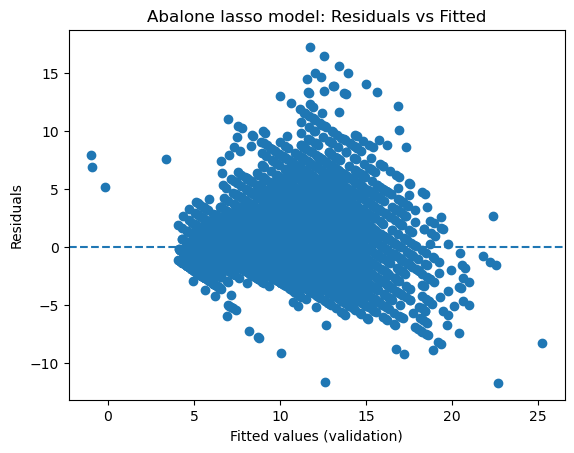

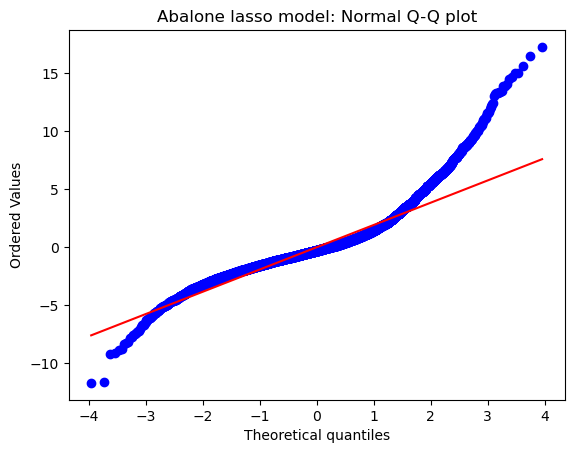

In [16]:

# Residual diagnostics for Abalone lasso model

import scipy.stats as stats

resid_lasso_ab = y_valid_ab - preds_valid_lasso

plt.figure()
plt.scatter(preds_valid_lasso, resid_lasso_ab)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values (validation)")
plt.ylabel("Residuals")
plt.title("Abalone lasso model: Residuals vs Fitted")

plt.figure()
stats.probplot(resid_lasso_ab, dist="norm", plot=plt)
plt.title("Abalone lasso model: Normal Q-Q plot")
plt.show()


In [ ]:
## Residual Diagnostics Summary – Abalone Lasso Model

The plots above evaluate the assumptions for the Lasso regression on the Abalone dataset:

- **Residuals vs. Fitted:**  
  The residuals show a roughly horizontal band around zero, though there is some spread increasing with fitted values.  
  This indicates mild heteroskedasticity, which is common in biological measurement data.

- **Normal Q–Q Plot:**  
  Residuals deviate slightly from the line at the tails, suggesting the presence of non-normality.  
  Given the large sample size and the predictive nature of the task, this is not a major concern.

Overall, the linear model assumptions are reasonably satisfied for Lasso, and the model remains appropriate for prediction in this context.


## 4. Interpretation and Conclusions

- The **lasso model** provides a sparse set of predictors with good predictive performance; non-zero coefficients highlight which physical features of the abalone are most associated with age (rings).  
- The **PCR model** reduces dimensionality using principal components and achieves similar RMSE, but its coefficients live on components rather than original variables, so interpretation is harder.  
- Residual diagnostics suggest the linear model is reasonably appropriate, with mild deviations from homoskedasticity and normality typical of real data.  
- For interpretation and communication of results, the lasso-informed best subset is preferred. For pure prediction, both lasso and PCR are competitive; Kaggle submissions are generated as `submission_lasso.csv` and `submission_pcr.csv`.
